<hr>
<font size=5 color='#3E54D3'> <b> Flower Classification - K. Weigel </b> </font>
<hr/>


The objective of this project is to analyze flower dataset (https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset) and create a machine learning model that correctly classifies flower images.

The dataset consists of 5 different flower classes:
* Lilly
* Lotus
* Sunflower
* Orchid
* Tulip

Each flower class has 1000 images.

## 1 - Loading packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
import tensorflow.keras.layers as tfl
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import img_to_array, array_to_img
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet101V2

## 2 - Data preparation

Before we begin training models, we first need to read in our data and split it into train, validation and test sets. Additionally we will use `ImageDataGenerator` to augment the dataset, and make our classifier less prone to overfitting.

In [ ]:
# zip_ref = zipfile.ZipFile('flowers.zip', 'r')
# zip_ref.extractall()
# zip_ref.close()

In [2]:
flower_path = 'flower_images'

In [3]:
n_lilly = len(os.listdir(os.path.join(flower_path , 'Lilly')))
n_lotus = len(os.listdir(os.path.join(flower_path , 'Lotus')))
n_orchid = len(os.listdir(os.path.join(flower_path , 'Orchid')))
n_sunfl = len(os.listdir(os.path.join(flower_path , 'Sunflower')))
n_tulip = len(os.listdir(os.path.join(flower_path , 'Tulip')))

print('Number of lilly images: ', n_lilly)
print('Number of lotus images: ', n_lotus)
print('Number of orchid images: ', n_orchid)
print('Number of sunflower images: ', n_sunfl)
print('Number of tulip images: ', n_tulip)

Number of lilly images:  1000
Number of lotus images:  1000
Number of orchid images:  1000
Number of sunflower images:  1000
Number of tulip images:  1000


In [ ]:
def split_data(data_source, test_size=0.1):
    classes = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
    train_size = 1 - 2 * test_size

    try:
        os.mkdir('train')
        os.mkdir('val')
        os.mkdir('test')
    except OSError:
        print('Error making directory')

    for label in classes:
        try:
            os.mkdir('train/' + label)
            os.mkdir('val/' + label)
            os.mkdir('test/' + label)
        except OSError:
            print('Error making directory')

        images_list = os.listdir(os.path.join(data_source, label))
        np.random.shuffle(images_list)
        train, val, test = np.split(np.array(images_list),
                                    [int(len(images_list) * train_size),
                                     int(len(images_list) * (train_size + test_size))])

        train = [os.path.join(data_source, label, name) for name in train.tolist()]
        val = [os.path.join(data_source, label, name) for name in val.tolist()]
        test = [os.path.join(data_source, label, name) for name in test.tolist()]

        for name in train:
            shutil.copy(name, 'train/' + label)

        for name in val:
            shutil.copy(name, 'val/' + label)

        for name in test:
            shutil.copy(name, 'test/' + label)

In [ ]:
# run once
# split_data(flower_path)

In [4]:
classes = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
n_train = sum([len(os.listdir('train/' + name)) for name in classes])
n_val = sum([len(os.listdir('val/' + name)) for name in classes])
n_test = sum([len(os.listdir('test/' + name)) for name in classes])

print('Number of training images: ', n_train)
print('Number of validation images: ', n_val)
print('Number of test images: ', n_test)

Number of training images:  4000
Number of validation images:  500
Number of test images:  500


In [5]:
datagen_train = ImageDataGenerator(
#    rescale = 1./255, # rescaling will be done inside cnn
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen_test = ImageDataGenerator()

train_ds = datagen_train.flow_from_directory(
    'train',
    target_size=(224, 224),
    batch_size=32)

val_ds = datagen_test.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

test_ds = datagen_test.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [6]:
def plot_data(generator):
    imgs, labels = generator.next()
    names = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

    fig = plt.figure(figsize=(12, 6))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(imgs[i]/255)
        plt.title(names[int(labels[i].nonzero()[0])])
        plt.axis('off')

    fig.tight_layout()

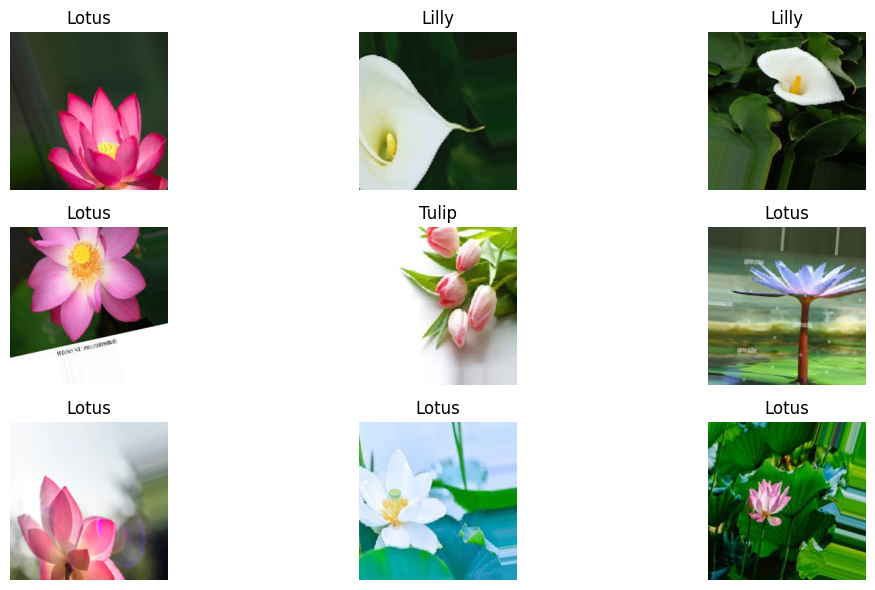

In [7]:
plot_data(train_ds)

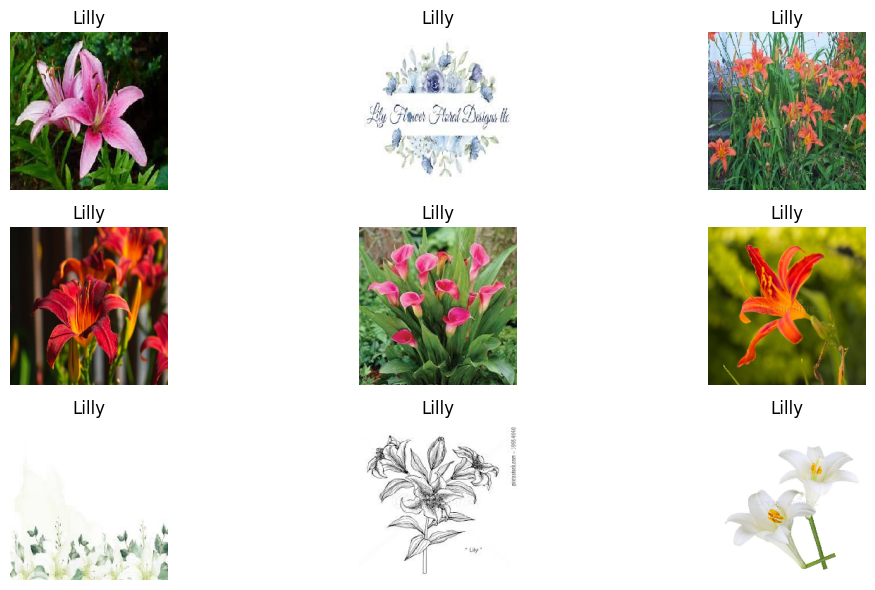

In [8]:
plot_data(val_ds)

## 3 - Convolutional Neural Network

We will first train a convolutional neural network with keras's Sequential API.

### 3.1 - Model details

We pass the images through a series of four convolutional blocks, each one consisting of convolutional layer, followed by BatchNorm, ReLU and a pooling layer. After each block the number of channels is doubled, while the spatial dimension is reduced by half. After the last block, we flatten the result and pass it through a fully-connected layers for classification.

In [12]:
model_cnn = tf.keras.Sequential([
    tfl.Rescaling(1./255, input_shape=(224, 224, 3)),
    tfl.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size=(2, 2)),
    tfl.Dropout(0.1),

    tfl.Conv2D(64, (3, 3), padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size=(2, 2)),
    tfl.Dropout(0.1),

    tfl.Conv2D(128, (3, 3), padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size=(2, 2)),
    tfl.Dropout(0.2),

    tfl.Conv2D(256, (3, 3), padding='same'),
    tfl.BatchNormalization(),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size=(2, 2)),
    tfl.Dropout(0.2),

    tfl.Flatten(),
    tfl.Dense(256, activation='relu'),
    tfl.Dense(5, activation='softmax')
])

In [13]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 32)     

In [14]:
model_cnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0008),
                  metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=8,
    restore_best_weights=True)

model_cnn_hist = model_cnn.fit(train_ds,
                               epochs=50,
                               validation_data=val_ds,
                               callbacks=[early_stop])

Epoch 1/50
125/125 [==============================] - 42s 327ms/step - loss: 7.7443 - accuracy: 0.3565 - val_loss: 1.6577 - val_accuracy: 0.2080
Epoch 2/50
125/125 [==============================] - 41s 328ms/step - loss: 1.5290 - accuracy: 0.4568 - val_loss: 1.7962 - val_accuracy: 0.2580
Epoch 3/50
125/125 [==============================] - 41s 323ms/step - loss: 1.4137 - accuracy: 0.4855 - val_loss: 1.6653 - val_accuracy: 0.2900
Epoch 4/50
125/125 [==============================] - 41s 324ms/step - loss: 1.4912 - accuracy: 0.4918 - val_loss: 1.3293 - val_accuracy: 0.4480
Epoch 5/50
125/125 [==============================] - 41s 327ms/step - loss: 1.5363 - accuracy: 0.5017 - val_loss: 1.4305 - val_accuracy: 0.4960
Epoch 6/50
125/125 [==============================] - 41s 323ms/step - loss: 1.3727 - accuracy: 0.5297 - val_loss: 1.3404 - val_accuracy: 0.5460
Epoch 7/50
125/125 [==============================] - 41s 324ms/step - loss: 1.3541 - accuracy: 0.5393 - val_loss: 1.5554 - val_ac

In [16]:
model_cnn.save('model_cnn.h5')

In [ ]:
# model_cnn = tf.keras.models.load_model('model_cnn.h5')

In [15]:
# final test set accuracy
model_cnn.evaluate(test_ds)

16/16 [==============================] - 2s 110ms/step - loss: 0.7506 - accuracy: 0.7100


[0.7506199479103088, 0.7099999785423279]

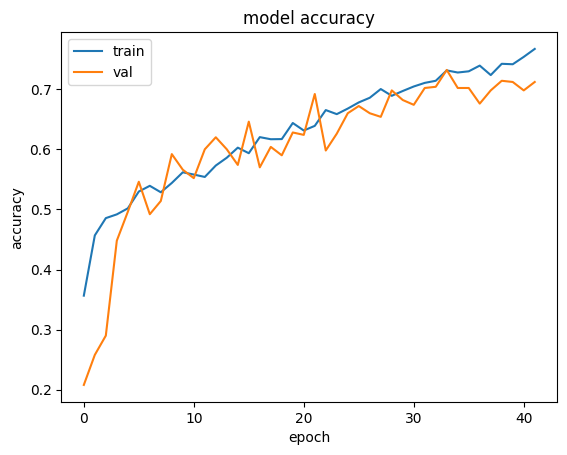

In [17]:
plt.plot(model_cnn_hist.history['accuracy'])
plt.plot(model_cnn_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

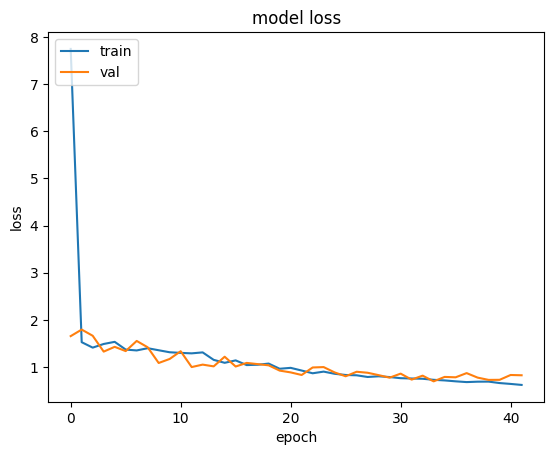

In [18]:
plt.plot(model_cnn_hist.history['loss'])
plt.plot(model_cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
predicted_val = np.argmax(model_cnn.predict(test_ds), axis=1)

16/16 [==============================] - 2s 85ms/step


In [20]:
cm = confusion_matrix(test_ds.classes, predicted_val)

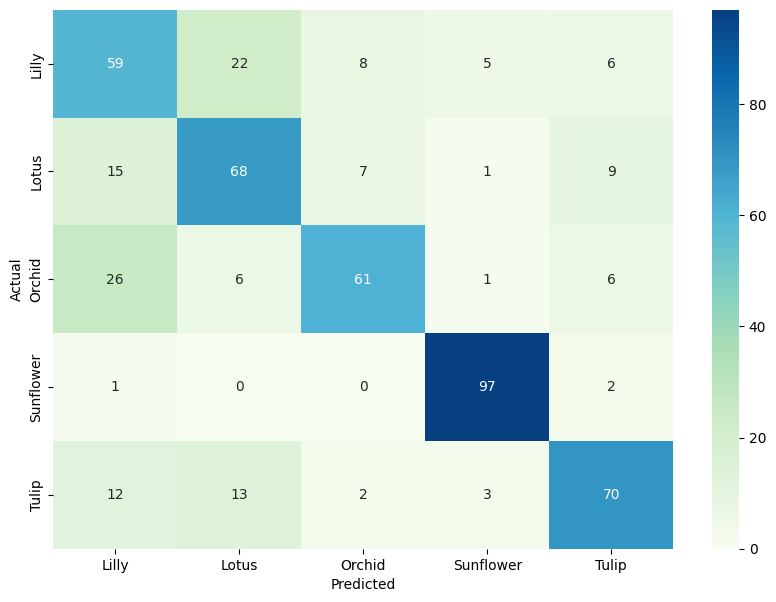

In [21]:
classes = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
df_cm = pd.DataFrame(cm, index = [cl for cl in classes],
                  columns = [cl for cl in classes])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
cr = classification_report(test_ds.classes, predicted_val, target_names=classes)
print(cr)

              precision    recall  f1-score   support

       Lilly       0.52      0.59      0.55       100
       Lotus       0.62      0.68      0.65       100
      Orchid       0.78      0.61      0.69       100
   Sunflower       0.91      0.97      0.94       100
       Tulip       0.75      0.70      0.73       100

    accuracy                           0.71       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.72      0.71      0.71       500



In [23]:
def incorrect_images(model, num_images=100):
    """Retrieve incorrectly classified images."""
    images = []
    labels = []
    predicted_labels = []
    # loop through all batches in the test set
    for (imgs, imgs_labels) in test_ds:
        # loop through images in the current batch
        for i, img in enumerate(imgs):
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            result = np.argmax(model.predict(img, verbose=0))
            true_label = int(imgs_labels[i].nonzero()[0])
            if result != true_label:
                images.append(img)
                labels.append(true_label)
                predicted_labels.append(result)
        if len(images) >= num_images:
            break

    return images, labels, predicted_labels

In [24]:
def plot_random_images(images, labels, predicted_labels, num_images=16, random=True):
    """Plot incorrectly classified images."""
    fig = plt.figure(figsize=(12, 12))
    names = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
    grid_size = int(num_images // np.sqrt(num_images))

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        if random == True:
            img_idx = np.random.randint(0, len(images) - 1)
        else:
            img_idx = i
        plt.imshow(images[img_idx][0, :, :, :]/255)
        plt.title('correct class: ' + names[labels[img_idx]] + '\n predicted class: ' + names[predicted_labels[img_idx]])
        plt.axis('off')

    fig.tight_layout()
    plt.show()

In [25]:
images, labels, predicted_labels = incorrect_images(model_cnn, 16)

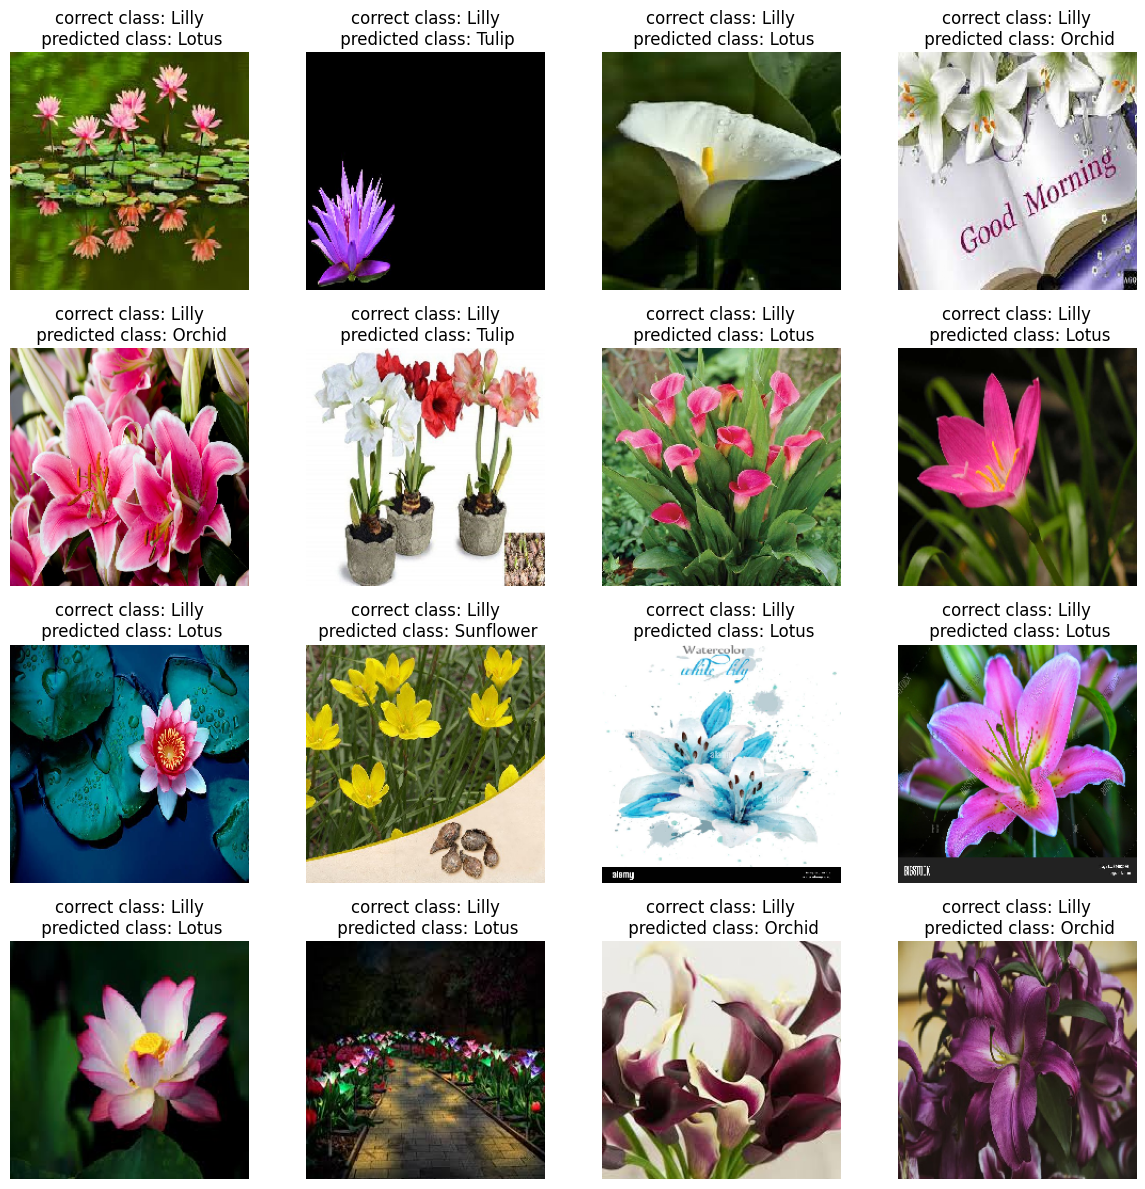

In [26]:
plot_random_images(images, labels, predicted_labels, random=False)

## 4 - Residual Neural Network

Residual Neural Network (or ResNet) was first introduced in 2015 ([Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1603.05027)) as a way to train deep models without degradation problem.
The ResNet architecture introduced the concept called Residual Blocks. Residual Blocks are skip connection blocks that learn residual mappings with reference to the block inputs, instead of learning unreferenced functions. ResNets are made by stacking these residual blocks together.

Thanks to the skip connections, instead of trying to directly fit an underlying mapping, the network can instead fit a residual mapping. So, instead of say $H(x)$, initial mapping, let the network fit,

$$
F(x) = H(x) - x \text{ which gives } H(x) = F(x) + x.
$$

Now if, for example, an identity mapping were ideal, then it would be easier to optimize the residual mapping and push the weights to zero than to fit an identity mapping by a stack of nonlinear layers.


<!-- | ![space-1.jpg](https://drive.google.com/uc?export=view&id=1XwN6v5x6xaC7ejFLNunXhTehP6QuMx02) |
|:--:|
| *Residual block* |
 -->


<img src="images/resnet.png" style="width:600px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Residual block</b> </center></caption>



### 4.1 - ResNet101

ResNet101 contains is 101 layers deep and is comprised of 33 residual blocks. Initially, this network was trained on the ImageNet dataset, which includes 1000 object classes. The original architecture has been illustrated in Fig. 2. For transfer learning purposes, we retrain the network's classification block to fit the correct number of classes. We could also try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When fine-tuning the network, we use smaller learning rate.

<img src="images/resnet101.png" style="width:100%;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>ResNet101 architecture</b> </center></caption>
    

In [27]:
model_base = ResNet101V2(
    input_shape=(224, 224, 3),
    include_top=False,
)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable = False

# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # rescale images to be between -1 and 1

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = model_base(x)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.5)(x)
outputs = tfl.Dense(5, activation="softmax")(x)

model_resnet = tf.keras.Model(inputs=inputs, outputs=outputs)
model_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=5,
    restore_best_weights=True)

# for fine tuning a pre-trained model we should use smaller learning rate
model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])

model_resnet_history = model_resnet.fit(x=train_ds,
                                        validation_data=val_ds,
                                        epochs=50,
                                        callbacks=[early_stop])

Epoch 1/50
125/125 [==============================] - 64s 460ms/step - loss: 0.5999 - accuracy: 0.7793 - val_loss: 0.3317 - val_accuracy: 0.9060
Epoch 2/50
125/125 [==============================] - 55s 438ms/step - loss: 0.2122 - accuracy: 0.9290 - val_loss: 0.1620 - val_accuracy: 0.9380
Epoch 3/50
125/125 [==============================] - 55s 437ms/step - loss: 0.1224 - accuracy: 0.9595 - val_loss: 0.1684 - val_accuracy: 0.9560
Epoch 4/50
125/125 [==============================] - 55s 439ms/step - loss: 0.0809 - accuracy: 0.9718 - val_loss: 0.1366 - val_accuracy: 0.9520
Epoch 5/50
125/125 [==============================] - 55s 437ms/step - loss: 0.0695 - accuracy: 0.9783 - val_loss: 0.2039 - val_accuracy: 0.9420
Epoch 6/50
125/125 [==============================] - 55s 437ms/step - loss: 0.0604 - accuracy: 0.9797 - val_loss: 0.1714 - val_accuracy: 0.9520
Epoch 7/50
125/125 [==============================] - 55s 440ms/step - loss: 0.0403 - accuracy: 0.9868 - val_loss: 0.1287 - val_ac

In [29]:
model_resnet.save('model_resnet.h5')

In [ ]:
# model_resnet = tf.keras.models.load_model('model_resnet.h5')

In [30]:
model_resnet.evaluate(test_ds)

16/16 [==============================] - 5s 318ms/step - loss: 0.1402 - accuracy: 0.9560


[0.1401846557855606, 0.9559999704360962]

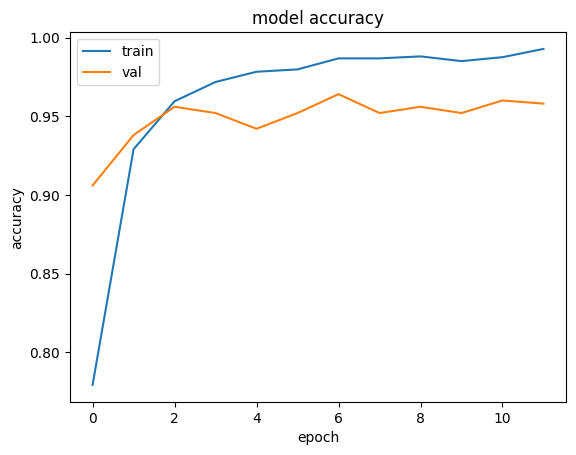

In [31]:
plt.plot(model_resnet_history.history['accuracy'])
plt.plot(model_resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

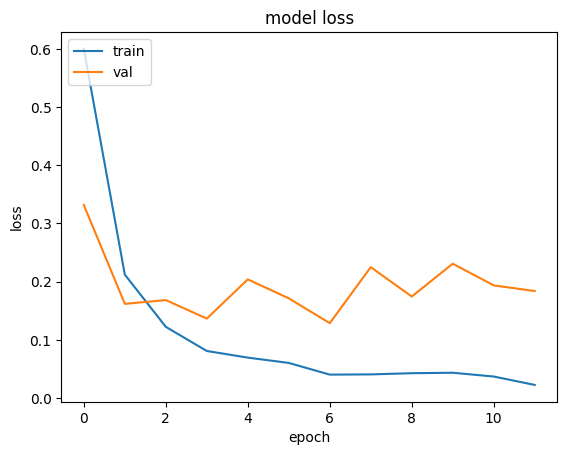

In [32]:
plt.plot(model_resnet_history.history['loss'])
plt.plot(model_resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
predicted_val = np.argmax(model_resnet.predict(test_ds), axis=1)

16/16 [==============================] - 6s 317ms/step


In [34]:
cm = confusion_matrix(test_ds.classes, predicted_val)

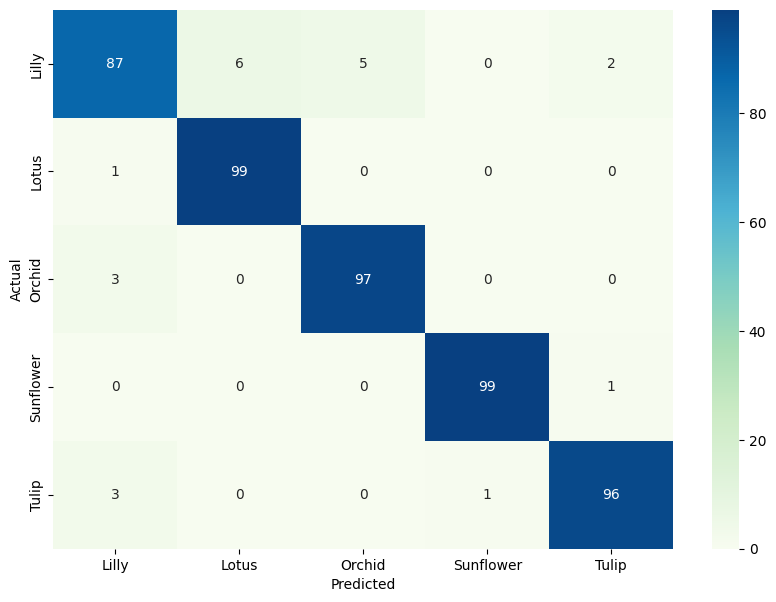

In [35]:
classes = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
df_cm = pd.DataFrame(cm, index = [cl for cl in classes],
                  columns = [cl for cl in classes])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
cr = classification_report(test_ds.classes, predicted_val, target_names=classes)
print(cr)

              precision    recall  f1-score   support

       Lilly       0.93      0.87      0.90       100
       Lotus       0.94      0.99      0.97       100
      Orchid       0.95      0.97      0.96       100
   Sunflower       0.99      0.99      0.99       100
       Tulip       0.97      0.96      0.96       100

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



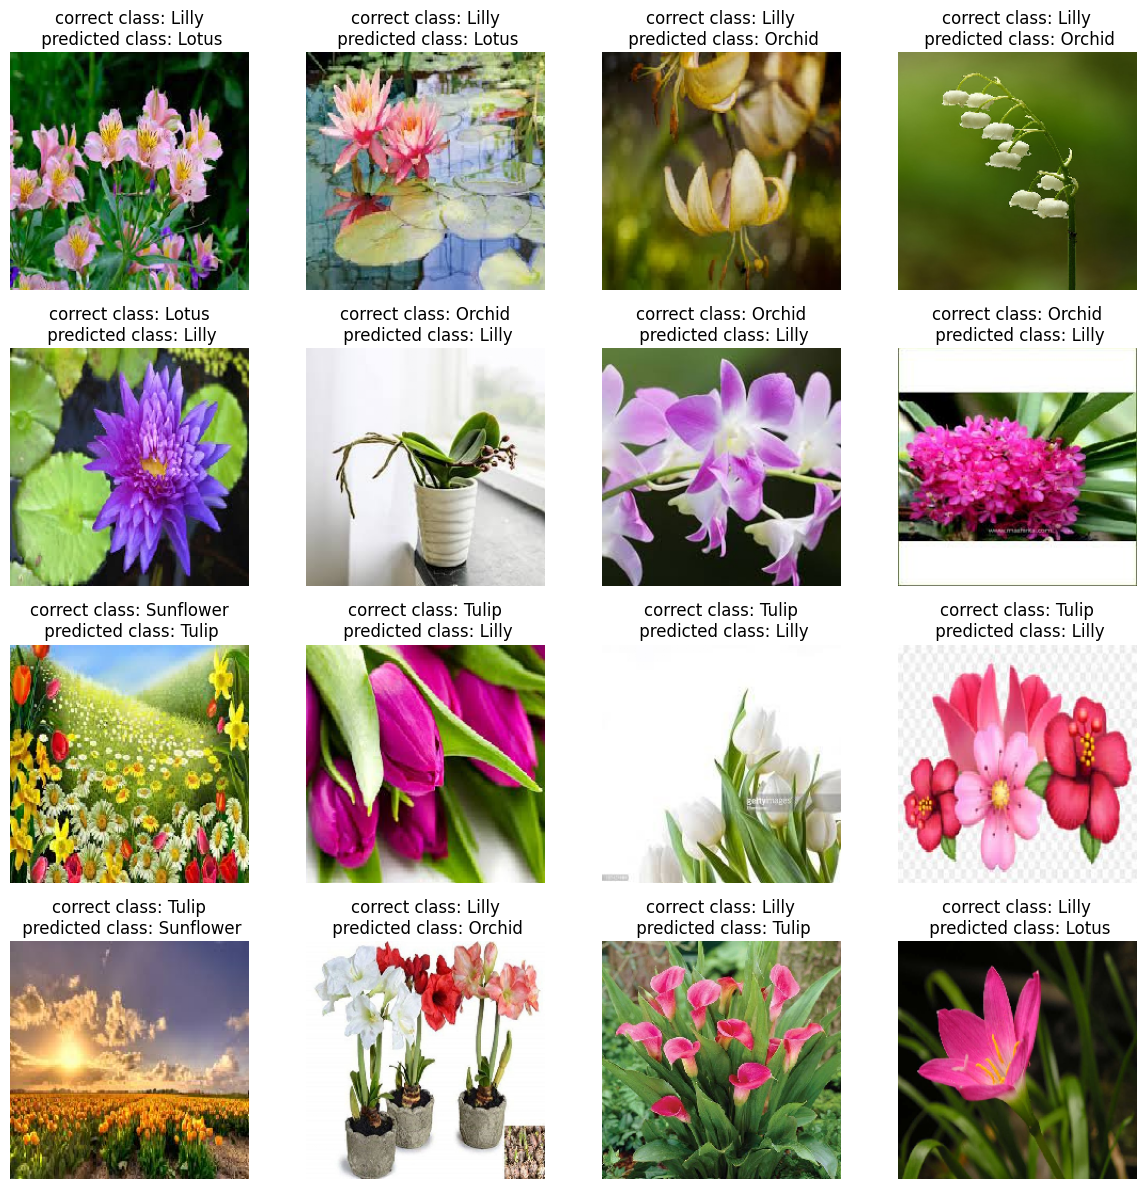

In [37]:
images, labels, predicted_labels = incorrect_images(model_resnet, 16)
plot_random_images(images, labels, predicted_labels, random=False)